<a href="https://colab.research.google.com/github/chacha86/pythonai/blob/main/Copy_of_%EC%84%A0%ED%98%95%ED%9A%8C%EA%B7%80_%EC%98%81%ED%99%94_%ED%8F%89%EC%A0%90_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
## 평점을 예측하는 모델 만들기

## 감독, 장르, 배급, 개봉, 등급을 이용해서 평점 예측하기
## 범주데이터를 수치데이터로 바꿔야 함.
## 인코딩 -> 
## 원핫인코딩 -> 범주가 많으면 데이터가 많이 생겨서 성능이 떨어짐
## 타겟인코딩, 빈도수 인코딩, 레이블 인코딩

## 다중회귀로 학습

## 평가


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mv = pd.read_excel('/content/movie2.xlsx')

In [4]:
#mv.info()
'''
'제목', '개봉', '등급', '장르', '국가', '러닝타임', '배급', '원작', '감독', '평점', '참여수',
       '남자평균', '여자평균', 'OST', '영상미', '스토리', '연기', '연출', '10대_평점', '20대_평점',
       '30대_평점', '40대_평점', '50대_평점', '원제', 'male', 'female', '관객수_x', '개요',
       '수상', '재개봉', '채널', '10대_비율', '20대_비율', '30대_비율', '40대_비율', '50대_비율'
'''
data = mv[['개봉', '등급', '장르', '배급', '감독', '평점']]

data['등급'].value_counts() # 원핫 인코딩

data['개봉'].value_counts() # 타겟 인코딩
data['장르'].value_counts() # 타겟 인코딩
data['배급'].value_counts() # 타겟 인코딩
data['감독'].value_counts() # 타겟 인코딩

유야마 쿠니히코     8
리들리 스콧       6
이준익          6
제임스 완        6
자움 콜렛 세라     6
            ..
폴 그린그래스      1
에드워드 즈윅      1
이재한          1
던칸 존스        1
크리스토퍼 보글리    1
Name: 감독, Length: 785, dtype: int64

In [5]:
data2 = data.fillna('')



from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

## 1. 등급 컬럼을 원핫 인코딩해주세요.
one_hot_target = data2[['등급']]

col_names = data2['등급'].unique()

encoded_target = encoder.fit_transform(one_hot_target).toarray()
target_1hot = pd.DataFrame(encoded_target, columns = '등급_' + col_names)

## 2. 등급을 제외한 나머지 컬럼을 타겟 인코딩 해주세요.
## 감독
data2["감독_인코딩"] = data2.groupby("감독")["평점"].transform("mean")

## 장르, 배급, 개봉 타겟 인코딩 해주세요.
data2["장르_인코딩"] = data2.groupby("장르")["평점"].transform("mean")
data2["배급_인코딩"] = data2.groupby("배급")["평점"].transform("mean")
data2["개봉_인코딩"] = data2.groupby("개봉")["평점"].transform("mean")


## 3. 인코딩 된 데이터만 추리기

data2.columns

target_encoded_df = data2[['평점', '감독_인코딩', '장르_인코딩', '배급_인코딩',
       '개봉_인코딩']]

data3 = pd.concat([target_encoded_df, target_1hot], axis=1)


In [6]:
data3.columns

Index(['평점', '감독_인코딩', '장르_인코딩', '배급_인코딩', '개봉_인코딩', '등급_15세 관람가',
       '등급_청소년 관람불가', '등급_전체 관람가', '등급_12세 관람가', '등급_'],
      dtype='object')

In [7]:
## 4.학습데이터와 테스트 데이터를 문제와 정답 나눠서 8:2로 분리해주세요. 

from sklearn.model_selection import train_test_split

train_data = data3[['감독_인코딩', '장르_인코딩', '배급_인코딩',
       '개봉_인코딩', '등급_15세 관람가',
       '등급_청소년 관람불가', '등급_전체 관람가', '등급_12세 관람가']]

target_data = data3['평점']

trd, tsd, trt, tst = train_test_split(train_data, target_data, train_size=0.8, random_state=42)

## 5. 선형회귀 모델로 학습시키고 평가해주세요.

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(trd, trt)

lr.score(trd, trt), lr.score(tsd, tst)

## 타겟인코딩 -> 장점 및 단점.
## 쉽게 과적합
## 적은 데이터일 경우 좋은 성능을 내기 어렵다.


(0.8311926873098582, 0.853077199002332)

In [8]:
## 교차 검증 기법
## - 데이터를 효율적으로 사용 가능
## - 학습데이터를 다양한 패턴으로 학습하기 때문에 특정 패턴에 고정되지 않고 유연하게 학습 가능 => 과적합을 완화한다.
## 단점
## - 여러번 학습하기 때문에 학습에 시간이 걸릴 수 있음.

from sklearn.model_selection import cross_val_score

## 교차 검증할 모델, 폴드에 사용할 데이터, 데이터의 정답, 평가지표, 폴드 수)
## 회귀 평가 지표 -> r2, RMSE, MAE
scores = cross_val_score(lr, trd, trt, scoring='r2', cv=5)



In [9]:
np.mean(scores)

0.821195949506952

In [10]:
## 점수를 좀 더 올릴 수는 없을까?
## 1. 데이터 튜닝
### 1.1 스케일링
### 1.2 피처 엔지니어링

#### 1.2.1 나머지 특성들을 학습에 사용해주세요.
####   - 사용할만한 컬럼인지 판단
## - 제목은 중복도(카디널리티) 낮으면 별로
## - 개봉은 중복도가 낮은데, 높일 수 있음.(년월별로) (O)
## - 평점에 관련된 데이터는 제외 (O)
## - 결측치가 너무 많은 데이터 제외 -> 결측치 400개 이상인 것 버림 (O)

del_target = mv.columns.values[mv.isna().sum() > 400]
mv2 = mv.drop(del_target, axis=1)


del_target2 = mv2.columns[mv2.columns.str.contains('_평점|평균|참여수')]

mv3 = mv2.drop(del_target2, axis=1)


mv3['개봉'] = mv3['개봉'].str[:7]
####   - 숫자데이터인데 문자로 되어 있는 경우 -> 형변환 (O)
####   - 결측치 처리
####   - 인코딩이 필요하면 인코딩, 스케일링이 필요하면 스케일링

#### 1.2.2 특성을 조합해서 특성의 개수와 차수 늘리기
####   - 차수를 몇차까지 할 것인지
####   - 과적합을 해결하기 - 규제




In [11]:
mv4 = mv3.drop('제목', axis=1)

### 1. 결측치를 제외한 값을 추린다
idx = mv4['관객수_x'].notna()
popul = mv4.loc[idx, '관객수_x']

### 2. 명을 없앤다
popul2 = popul.str.replace('명', '')
### 3. 만이 붙은 행만 추린다.
man_idx = popul2.str.contains('만')
popul3 = popul2[man_idx]
### 4. 만을 없애고 숫자 바꾼다.
### 5. * 10000을 해준다.
popul4 = popul3.str.replace('만', '').str.replace(',', '').astype('float') * 10000

### 6. 원래 데이터를 찾아서 대입해준다.

mv4.loc[idx, '관객수_x'] = popul4

In [12]:
mv4['관객수_x'] = mv4['관객수_x'].astype('float')

In [13]:
mv4[['10대_비율', '20대_비율', '30대_비율', '40대_비율', '50대_비율']] = mv4[['10대_비율', '20대_비율', '30대_비율', '40대_비율', '50대_비율']].applymap(lambda x : str(x).replace('%','')).astype('float')

In [14]:
'''
'개봉', '등급', '장르', '국가', '러닝타임', '배급', '감독', '평점', 'OST', '영상미', '스토리',
       '연기', '연출', '관객수_x', '10대_비율', '20대_비율', '30대_비율', '40대_비율', '50대_비율'
'''
#mv4.info()
mv4.loc[:, ['개봉', '등급', '장르', '국가', '러닝타임', '배급', '감독']] = mv4[['개봉', '등급', '장르', '국가', '러닝타임', '배급', '감독']].fillna('')




In [15]:
#mv4.info()


## 숫자형 데이터 결측치 처리
pd.options.display.float_format = '{:.2f}'.format
#mv4.describe()

## 평균으로 대체

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

## 숫자
mv4_num = mv4.drop(['개봉', '등급', '장르', '국가', '러닝타임', '배급', '감독', '평점'], axis=1)
## 범주
mv4_cate = mv4[['개봉', '등급', '장르', '국가', '러닝타임', '배급', '감독', '평점']]
## 타겟
mv4_target = mv4['평점']

imputed_mv4_num = imputer.fit_transform(mv4_num)

imputed_mv4_num_df = pd.DataFrame(imputed_mv4_num, columns = mv4_num.columns)
imputed_mv4_num_df.info()

## 스케일링 -> 학습데이터를 기준으로 스케일링
## 타겟 인코딩 -> 학습데이터를 기준으로 인코딩

from sklearn.model_selection import train_test_split

## 숫자형 데이터 분리
trd_num, tsd_num, trt, tst = train_test_split(imputed_mv4_num_df, mv4_target, train_size=0.8, random_state=42)

## 범주형 데이터 분리. 정답 데이터는 위에서 얻었으므로 여기서는 제외
trd_cate, tsd_cate = train_test_split(mv4_cate, train_size=0.8, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OST     1188 non-null   float64
 1   영상미     1188 non-null   float64
 2   스토리     1188 non-null   float64
 3   연기      1188 non-null   float64
 4   연출      1188 non-null   float64
 5   관객수_x   1188 non-null   float64
 6   10대_비율  1188 non-null   float64
 7   20대_비율  1188 non-null   float64
 8   30대_비율  1188 non-null   float64
 9   40대_비율  1188 non-null   float64
 10  50대_비율  1188 non-null   float64
dtypes: float64(11)
memory usage: 102.2 KB


In [16]:
## 숫자형 데이터 전처리 - 스케일링
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_trd_num = ss.fit_transform(trd_num)
scaled_tsd_num = ss.transform(tsd_num)

scaled_trd_num_df = pd.DataFrame(scaled_trd_num, columns=trd_num.columns)
scaled_tsd_num_df = pd.DataFrame(scaled_tsd_num, columns=tsd_num.columns)

In [17]:
## 범주형 데이터 전처리 - 인코딩
## 학습 데이터 인코딩
### 등급 컬럼을 원핫 인코딩
trd_one_hot_target = trd_cate[['등급']]

trd_col_names = trd_cate['등급'].unique()

encoded_trd_grade = encoder.fit_transform(trd_one_hot_target).toarray()
trd_grade_1hot = pd.DataFrame(encoded_trd_grade, columns = '등급_' + trd_col_names).drop('등급_', axis=1)

## 2. 등급을 제외한 나머지 컬럼을 타겟 인코딩 
trd_cate["감독_인코딩"] = trd_cate.groupby("감독")["평점"].transform("mean")
trd_cate["장르_인코딩"] = trd_cate.groupby("장르")["평점"].transform("mean")
trd_cate["배급_인코딩"] = trd_cate.groupby("배급")["평점"].transform("mean")
trd_cate["개봉_인코딩"] = trd_cate.groupby("개봉")["평점"].transform("mean")
trd_cate["국가_인코딩"] = trd_cate.groupby("국가")["평점"].transform("mean")

## 3. 필요한 컬럼만 합치기

trd_cate_tmp = trd_cate[['감독_인코딩', '장르_인코딩', '배급_인코딩', '개봉_인코딩', '국가_인코딩']]
trd_grade_1hot_tmp = trd_grade_1hot[['등급_전체 관람가', '등급_12세 관람가', '등급_15세 관람가', '등급_청소년 관람불가']]
trd_cate_rst = pd.concat([trd_cate_tmp.reset_index(drop=True), trd_grade_1hot_tmp.reset_index(drop=True)], axis=1)


In [18]:
## 테스트 데이터 인코딩
### 등급 컬럼을 원핫 인코딩
tsd_one_hot_target = tsd_cate[['등급']]
tsd_col_names = tsd_cate['등급'].unique()

encoded_tsd_grade = encoder.fit_transform(tsd_one_hot_target).toarray()
tsd_grade_1hot = pd.DataFrame(encoded_tsd_grade, columns = '등급_' + tsd_col_names)

## 2. 등급을 제외한 나머지 컬럼을 타겟 인코딩 
tsd_cate["감독_인코딩"] = tsd_cate.groupby("감독")["평점"].transform("mean")
tsd_cate["장르_인코딩"] = tsd_cate.groupby("장르")["평점"].transform("mean")
tsd_cate["배급_인코딩"] = tsd_cate.groupby("배급")["평점"].transform("mean")
tsd_cate["개봉_인코딩"] = tsd_cate.groupby("개봉")["평점"].transform("mean")
tsd_cate["국가_인코딩"] = tsd_cate.groupby("국가")["평점"].transform("mean")

## 3. 필요한 컬럼만 합치기
tsd_cate_tmp = tsd_cate[['감독_인코딩', '장르_인코딩', '배급_인코딩', '개봉_인코딩', '국가_인코딩']]
tsd_grade_1hot_tmp = tsd_grade_1hot[['등급_전체 관람가', '등급_12세 관람가', '등급_15세 관람가', '등급_청소년 관람불가']]
tsd_cate_rst = pd.concat([tsd_cate_tmp.reset_index(drop=True), tsd_grade_1hot_tmp.reset_index(drop=True)], axis=1)

In [19]:
## 4. 숫자데이터와 범주 데이터 최종 합치기

trd_final = pd.concat([scaled_trd_num_df.reset_index(drop=True), trd_cate_rst], axis=1)
tsd_final = pd.concat([scaled_tsd_num_df.reset_index(drop=True), tsd_cate_rst], axis=1)



In [20]:
trd_final.info()
tsd_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OST          950 non-null    float64
 1   영상미          950 non-null    float64
 2   스토리          950 non-null    float64
 3   연기           950 non-null    float64
 4   연출           950 non-null    float64
 5   관객수_x        950 non-null    float64
 6   10대_비율       950 non-null    float64
 7   20대_비율       950 non-null    float64
 8   30대_비율       950 non-null    float64
 9   40대_비율       950 non-null    float64
 10  50대_비율       950 non-null    float64
 11  감독_인코딩       950 non-null    float64
 12  장르_인코딩       950 non-null    float64
 13  배급_인코딩       950 non-null    float64
 14  개봉_인코딩       950 non-null    float64
 15  국가_인코딩       950 non-null    float64
 16  등급_전체 관람가    950 non-null    float64
 17  등급_12세 관람가   950 non-null    float64
 18  등급_15세 관람가   950 non-null    float64
 19  등급_청소년 관

In [21]:
## 5. 모델 학습 및 평가
lr2 = LinearRegression()
lr2.fit(trd_final, trt)

lr2.score(trd_final, trt), lr2.score(tsd_final, tst) # 모델의 성능이 다소 아쉬움. 성능을 높이기 위해 다항회귀 고려.


(0.8230385130184165, 0.8980080126509301)

In [22]:
## 6. 다항회귀 적용
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
trd_final_poly = poly.fit_transform(trd_final)
tsd_final_poly = poly.fit_transform(tsd_final)

lr3 = LinearRegression()
lr3.fit(trd_final_poly, trt)

lr3.score(trd_final_poly, trt), lr3.score(tsd_final_poly, tst) # 성능은 조금 높아졌지만 테스트 점수가 낮은 과적합 발생

(0.8664337284633148, 0.7664289306259673)

In [23]:
## 과적합을 해결하기 위해 규제 적용(릿지)
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge = LinearRegression()
ridge.fit(trd_final_poly, trt)

ridge.score(trd_final_poly, trt), ridge.score(tsd_final_poly, tst)

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] # 하이퍼 파라미터 튜닝

trd_list = []
tsd_list = []
for alpha in alpha_list :
  ridge = Ridge(alpha=alpha)
  ridge.fit(trd_final_poly, trt)

  trd_list.append(ridge.score(trd_final_poly, trt))
  tsd_list.append(ridge.score(tsd_final_poly, tst))



<Axes: >

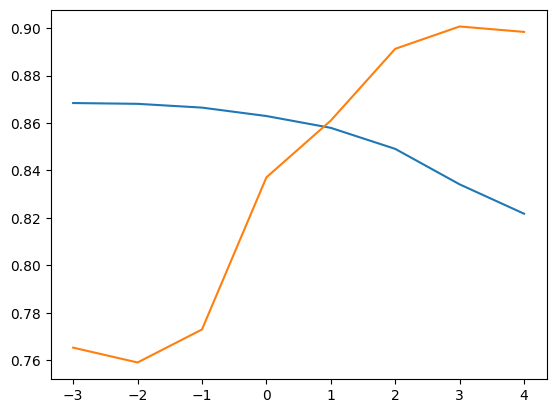

In [24]:
## 학습 점수와 테스트 점수가 둘 다 합리적으로 높은 지점을 찾기


sns.lineplot(x=np.log10(alpha_list), y=trd_list)
sns.lineplot(x=np.log10(alpha_list), y=tsd_list)

In [43]:
# alpha가 10일 때 가장 성능이 좋음
ridge.alpha = 10000
ridge.fit(trd_final_poly, trt)

ridge.score(trd_final_poly, trt), ridge.score(tsd_final_poly, tst)

(0.7954920113613885, 0.9091122304230981)

In [44]:
## 교차 검증

scores = cross_val_score(ridge, trd_final_poly, trt, scoring='r2', cv=5)

scores

array([0.76200401, 0.80044678, 0.73591322, 0.82642488, 0.75327344])

In [29]:
np.mean(scores)

0.6872612825657783

In [49]:
## 그리드 서치
## 파라미터 튜닝 
## 파라미터1 : 1, 10, 100
## 파라미터2 : 5, 8, 10
## 파라미터3 : 2, 4, 6

param_grid = {
    'alpha' : [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    #'param2' : [5, 8, 10],
    #'param3' : [2, 4, 6]
}

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5)

gs.fit(trd_final_poly, trt)

GridSearchCV(cv=5, estimator=Ridge(alpha=100000),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]})

In [50]:
print(gs.best_params_)
print(gs.best_score_)
best_ridge = gs.best_estimator_


{'alpha': 10000}
0.8043109127713617


In [51]:
## 교차 검증을 통해서 진행한 결과는 alpha가 10000일 때 82점 정도의 지표를 보여준다.
## 다항회귀로도 점수를 크게 올리지 못함.
best_ridge.score(trd_final_poly, trt), best_ridge.score(tsd_final_poly, tst)

(0.8217712023930879, 0.8984172692227439)

In [ ]:
## 이유는?
## 타겟인코딩 -> 과적합이 매우 잘 일어나는 방식
## 원핫인코딩 -> 범주 그룹수가 많으면 컬럼수가 엄청 많아짐. (차원의 저주). 과적합 유발.
## 레이블, 빈도수 등 -> 레이블은 범주에 랭킹을 부여, 빈도수는 평점과의 상관관계를 나타내기 힘듦
## 이런 이유로 범주값이 많은 데이터의 경우 선형회귀가 적절하지 않을 수 있다.

## 데이터를 튜닝, 파라미터 튜닝 -> 그럼에도 성능이 안나오는 경우
### 1. 데이터가 너무 적거나
### 2. 적합한 모델이 아니거나
### 3. 문제 정의를 잘못했거나
